In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import sys

sys.path.append("/home/dchen/BA_CH_EN/")


import os

os.environ[
    "CUDA_VISIBLE_DEVICES"
] = "-1"  # this line tells TensorFlow not to use any GPU
# Basics
import tensorflow as tf
import xarray as xr
import pandas as pd

# Helpful
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_local.EMOS_local_load_score import *  # Load EMOS_global_scores
from src.models.DRN.DRN_load_score import *  # Load DRN_scores
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models
from src.models.DRN.DRN_load_score_dummy_10 import *  # Load DRN_scores_10
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores
from src.models.U_net.unet import Unet
from src.models.U_net.u_net_tests_params import *
from src.models.U_net.unet import *
from src.models.U_net.u_net_predict_evaluate import *

<IPython.core.display.Javascript object>

### 0. Set Up

In [3]:
lead_time = 0
var_num = 5

land_sea_mask_dummy = np.load(
    "/Data/Delong_BA_Data/land_sea_mask_dummy/land_sea_mask_dummy.npy"
)
land_sea_mask_dummy = pad_land_sea_mask(land_sea_mask_dummy)
land_sea_mask_dummy = np.repeat(land_sea_mask_dummy[np.newaxis, ...], 357, axis=0)

# load data
test_var_mean = []
test_var_std = []
test_var_y = []
for var in range(6):
    (
        padded_test_data_mean,
        padded_test_data_std,
        padded_test_data_y,
    ) = u_net_load_test_data(var, lead_time)
    test_var_mean.append(padded_test_data_mean)
    test_var_std.append(padded_test_data_std)
    test_var_y.append(padded_test_data_y)

# Then, pack all of your input data into a list
test_inputs = test_var_mean + test_var_std + [land_sea_mask_dummy]

test_target = test_var_y[var_num]

<IPython.core.display.Javascript object>

In [4]:
def plot_losses(csv_filepath, starting_epoch=0, ending_epoch=1000000000):
    # Load the csv file into a pandas DataFrame
    data = pd.read_csv(csv_filepath).iloc[starting_epoch:ending_epoch]

    # Create a new figure
    plt.figure(figsize=(10, 5))

    # Plot the training loss
    plt.plot(data["epoch"], data["loss"], label="Train Loss")

    # Plot the validation loss
    plt.plot(data["epoch"], data["val_loss"], label="Validation Loss")

    # Set the labels for the x and y axes
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    # Set the title for the plot
    plt.title("Training and Validation Loss")

    # Enable the legend
    plt.legend()

    # Display the plot
    plt.show()
    return data

<IPython.core.display.Javascript object>

In [5]:
def test_best_model(path, var_num, lead_time):

    model = tf.keras.models.load_model(
        path,
        custom_objects={
            "crps_cost_function_U": crps_cost_function_U,
            "crps_cost_function_trunc_U": crps_cost_function_trunc_U,
            "CustomSchedule": CustomSchedule,
        },
    )
    # load land_sea_mask
    land_sea_mask_dummy = np.load(
        "/Data/Delong_BA_Data/land_sea_mask_dummy/land_sea_mask_dummy.npy"
    )
    land_sea_mask_dummy = pad_land_sea_mask(land_sea_mask_dummy)
    land_sea_mask_dummy = np.repeat(land_sea_mask_dummy[np.newaxis, ...], 357, axis=0)
    # load data
    test_var_mean = []
    test_var_std = []
    test_var_y = []
    for var in range(6):
        (
            padded_test_data_mean,
            padded_test_data_std,
            padded_test_data_y,
        ) = u_net_load_test_data(var, lead_time)
        test_var_mean.append(padded_test_data_mean)
        test_var_std.append(padded_test_data_std)
        test_var_y.append(padded_test_data_y)

    # Then, pack all of your input data into a list
    test_inputs = test_var_mean + test_var_std + [land_sea_mask_dummy]

    test_target = test_var_y[var_num]
    test_target_unpad = unpad_images_y(test_target)

    preds = model.predict(test_inputs, verbose=1)
    predictions_unpad = unpad_images(preds)
    if var_num in [5]:
        crps = crps_trunc
    else:
        crps = crps_normal

    scores = crps(
        mu=predictions_unpad[:, :, :, 0].flatten(),
        sigma=predictions_unpad[:, :, :, 1].flatten(),
        y=test_target_unpad.flatten(),
    )
    scores = scores.reshape((357, 120, 130)).mean(axis=0)
    return predictions_unpad, scores

<IPython.core.display.Javascript object>

In [6]:
def train_best_model(path, var_num, lead_time):

    model = tf.keras.models.load_model(
        path,
        custom_objects={
            "crps_cost_function_U": crps_cost_function_U,
            "crps_cost_function_trunc_U": crps_cost_function_trunc_U,
            "CustomSchedule": CustomSchedule,
        },
    )
    # load land_sea_mask
    land_sea_mask_dummy = np.load(
        "/Data/Delong_BA_Data/land_sea_mask_dummy/land_sea_mask_dummy.npy"
    )
    land_sea_mask_dummy = pad_land_sea_mask(land_sea_mask_dummy)
    land_sea_mask_dummy = np.repeat(land_sea_mask_dummy[np.newaxis, ...], 1429, axis=0)
    # load data
    train_var_mean = []
    train_var_std = []
    train_var_y = []
    for var in range(6):
        (
            padded_train_data_mean,
            padded_train_data_std,
            padded_train_data_y,
        ) = u_net_load_train_data(var, lead_time)
        train_var_mean.append(padded_train_data_mean)
        train_var_std.append(padded_train_data_std)
        train_var_y.append(padded_train_data_y)

    # Then, pack all of your input data into a list
    train_inputs = train_var_mean + train_var_std + [land_sea_mask_dummy]

    train_target = train_var_y[var_num]
    train_target_unpad = unpad_images_y(train_target)

    preds = model.predict(train_inputs, verbose=1)
    predictions_unpad = unpad_images(preds)
    if var_num in [5]:
        crps = crps_trunc
    else:
        crps = crps_normal

    scores = crps(
        mu=predictions_unpad[:, :, :, 0].flatten(),
        sigma=predictions_unpad[:, :, :, 1].flatten(),
        y=train_target_unpad.flatten(),
    )
    scores = scores.reshape((1429, 120, 130)).mean(axis=0)
    return predictions_unpad, scores


<IPython.core.display.Javascript object>

### Run 1

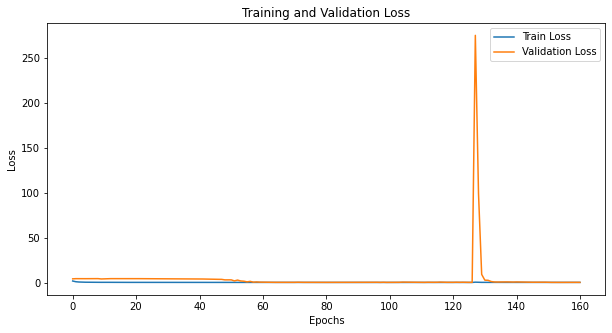

<IPython.core.display.Javascript object>

In [7]:
df_run_1_0 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_5_lead_0_lr_0.005_ep_3000_bs_128_filters24.csv"
)

In [8]:
df_run_1_0

,epoch,loss,val_loss
0,0,1.687831,4.091661
1,1,0.871599,4.290019
2,2,0.563612,4.314513
3,3,0.414710,4.292337
4,4,0.333101,4.257388
...,...,...,...
156,156,0.127107,0.148432
157,157,0.128533,0.136515
158,158,0.127763,0.221043
159,159,0.128272,0.186356


<IPython.core.display.Javascript object>

### Run 3

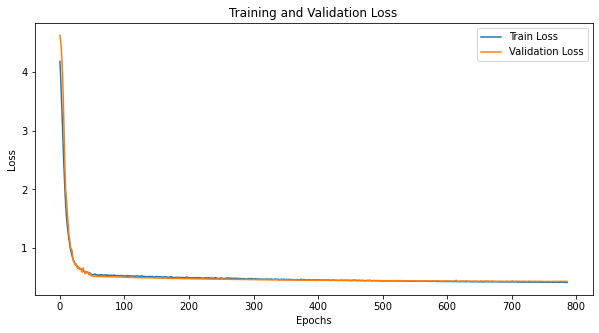

<IPython.core.display.Javascript object>

In [66]:
df_run_3_0 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_5_lead_0_lr_1e-05_ep_3000_bs_32_filters16.csv",
)

In [53]:
df_run_3_0

,epoch,loss,val_loss
700,700,0.421113,0.431811
701,701,0.423174,0.440601
702,702,0.420620,0.432023
703,703,0.419426,0.432104
704,704,0.422621,0.432296
...,...,...,...
782,782,0.412544,0.432067
783,783,0.412136,0.428586
784,784,0.412962,0.430366
785,785,0.412931,0.428596


<IPython.core.display.Javascript object>

In [54]:
test_preds, test_scores = test_best_model(
    "/Data/Delong_BA_Data/models/U_net/models/_unet_model_var_5_lead_0_lr_1e-05_ep_3000_bs_32_filters16.h5",
    5,
    0,
)

print(f"Number of Nan Values: {np.isnan(test_scores).sum()}")
print(f"Number of inf Values: {np.isinf(test_scores).sum()}")
testing = test_scores[~np.isnan(test_scores)]
testing = testing[~np.isinf(testing)]
testing.mean()

12/12 [==============================] - 13s 1s/step
Number of Nan Values: 0
Number of inf Values: 0


0.43437368

<IPython.core.display.Javascript object>

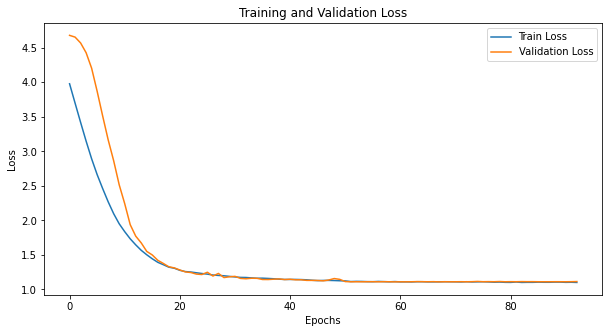

<IPython.core.display.Javascript object>

In [73]:
df_run_3_15 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_5_lead_15_lr_1e-05_ep_3000_bs_32_filters16.csv",
)

In [74]:
df_run_3_15

,epoch,loss,val_loss
0,0,3.977858,4.678954
1,1,3.697860,4.653574
2,2,3.419595,4.568988
3,3,3.148071,4.427667
4,4,2.891887,4.203538
...,...,...,...
88,88,1.106242,1.111858
89,89,1.105845,1.111735
90,90,1.102754,1.111282
91,91,1.103940,1.112315


<IPython.core.display.Javascript object>

In [75]:
test_preds, test_scores = test_best_model(
    "/Data/Delong_BA_Data/models/U_net/models/_unet_model_var_5_lead_15_lr_1e-05_ep_3000_bs_32_filters16.h5",
    5,
    15,
)

print(f"Number of Nan Values: {np.isnan(test_scores).sum()}")
print(f"Number of inf Values: {np.isinf(test_scores).sum()}")
testing = test_scores[~np.isnan(test_scores)]
testing = testing[~np.isinf(testing)]
testing.mean()

12/12 [==============================] - 13s 1s/step
Number of Nan Values: 0
Number of inf Values: 0


1.1213977

<IPython.core.display.Javascript object>

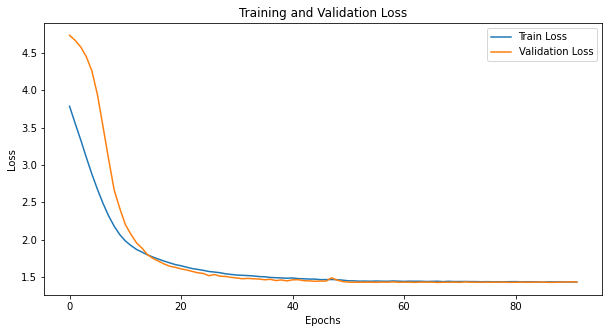

<IPython.core.display.Javascript object>

In [88]:
df_run_3_30 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_5_lead_30_lr_1e-05_ep_3000_bs_32_filters16.csv",
)

In [87]:
df_run_3_30.tail(50)

,epoch,loss,val_loss
42,42,1.475962,1.450849
43,43,1.472007,1.447418
44,44,1.471508,1.442602
45,45,1.464476,1.445272
46,46,1.465134,1.445079
47,47,1.465976,1.488559
48,48,1.463512,1.457825
49,49,1.457469,1.438818
50,50,1.448950,1.430958
51,51,1.448102,1.429629


<IPython.core.display.Javascript object>

In [78]:
test_preds, test_scores = test_best_model(
    "/Data/Delong_BA_Data/models/U_net/models/_unet_model_var_5_lead_30_lr_1e-05_ep_3000_bs_32_filters16.h5",
    5,
    30,
)

print(f"Number of Nan Values: {np.isnan(test_scores).sum()}")
print(f"Number of inf Values: {np.isinf(test_scores).sum()}")
testing = test_scores[~np.isnan(test_scores)]
testing = testing[~np.isinf(testing)]
testing.mean()

12/12 [==============================] - 13s 1s/step
Number of Nan Values: 0
Number of inf Values: 0


1.4318757

<IPython.core.display.Javascript object>

### Run 2

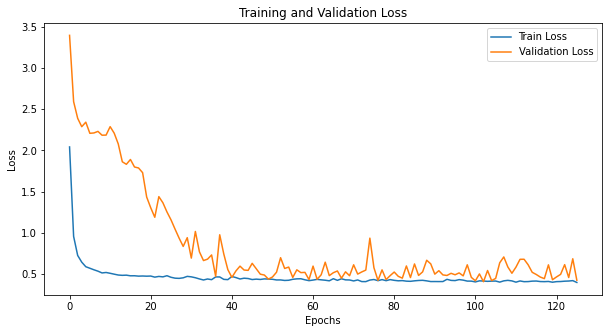

<IPython.core.display.Javascript object>

In [29]:
df_run_2_0 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_5_lead_0_lr_0.001_ep_3000_bs_64_filters16.csv"
)

In [30]:
df_run_2_0

,epoch,loss,val_loss
0,0,2.042186,3.395880
1,1,0.957084,2.591379
2,2,0.725772,2.389558
3,3,0.644439,2.287792
4,4,0.589081,2.342765
...,...,...,...
121,121,0.409519,0.496426
122,122,0.413557,0.614243
123,123,0.415591,0.458010
124,124,0.420286,0.685673


<IPython.core.display.Javascript object>

In [31]:
test_preds, test_scores = test_best_model(
    "/Data/Delong_BA_Data/models/U_net/models/_unet_model_var_5_lead_0_lr_0.001_ep_3000_bs_64_filters16.h5",
    5,
    0,
)

print(f"Number of Nan Values: {np.isnan(test_scores).sum()}")
print(f"Number of inf Values: {np.isinf(test_scores).sum()}")
testing = test_scores[~np.isnan(test_scores)]
testing = testing[~np.isinf(testing)]
testing.mean()

12/12 [==============================] - 14s 1s/step
Number of Nan Values: 0
Number of inf Values: 0


0.42250833

<IPython.core.display.Javascript object>

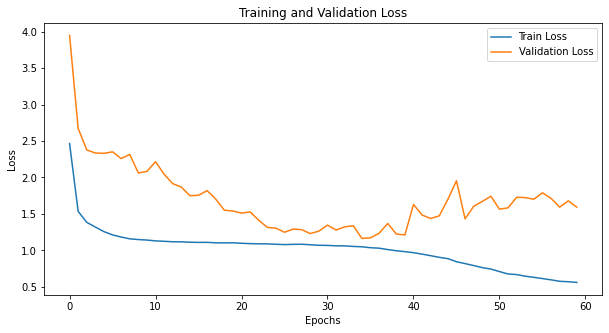

<IPython.core.display.Javascript object>

In [83]:
df_run_2_15 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_5_lead_15_lr_0.001_ep_3000_bs_64_filters16.csv"
)

In [84]:
df_run_2_15

,epoch,loss,val_loss
0,0,2.466026,3.950325
1,1,1.534103,2.675113
2,2,1.383894,2.377306
3,3,1.319317,2.335824
4,4,1.256530,2.330908
5,5,1.211649,2.351944
6,6,1.182606,2.259700
7,7,1.157447,2.315699
8,8,1.147681,2.061188
9,9,1.140817,2.083678


<IPython.core.display.Javascript object>

In [34]:
test_preds, test_scores = test_best_model(
    "/Data/Delong_BA_Data/models/U_net/models/_unet_model_var_5_lead_15_lr_0.001_ep_3000_bs_64_filters16.h5",
    5,
    15,
)

print(f"Number of Nan Values: {np.isnan(test_scores).sum()}")
print(f"Number of inf Values: {np.isinf(test_scores).sum()}")
testing = test_scores[~np.isnan(test_scores)]
testing = testing[~np.isinf(testing)]
testing.mean()

12/12 [==============================] - 13s 1s/step
Number of Nan Values: 0
Number of inf Values: 0


2.083296

<IPython.core.display.Javascript object>

### Test Final model

In [42]:
def final_model_run(lead_time, test=False, starting_epoch=0, ending_epoch=1000000000):
    df_run_final = plot_losses(
        f"/Data/Delong_BA_Data/models/U_net/csv_log_final/training_log_var_5_lead_{lead_time}.csv",
        starting_epoch,
        ending_epoch,
    )
    if test:
        test_preds, test_scores = test_best_model(
            f"/Data/Delong_BA_Data/models/U_net/models_final/unet_model_var_5_lead_{lead_time}.h5",
            5,
            lead_time,
        )

        print(f"Number of Nan Values: {np.isnan(test_scores).sum()}")
        print(f"Number of inf Values: {np.isinf(test_scores).sum()}")
        testing = test_scores[~np.isnan(test_scores)]
        testing = testing[~np.isinf(testing)]
        print(testing.mean())

    return df_run_final

<IPython.core.display.Javascript object>

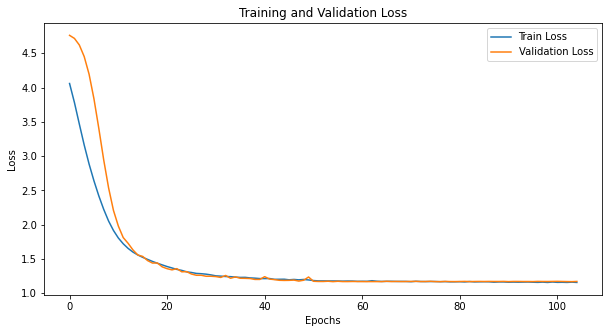

12/12 [==============================] - 13s 1s/step
Number of Nan Values: 0
Number of inf Values: 0
1.1646239


<IPython.core.display.Javascript object>

In [57]:
df_run_final = final_model_run(16, test=True)

In [44]:
df_run_final.min()

epoch       0.000000
loss        0.735501
val_loss    1.284528
dtype: float64

<IPython.core.display.Javascript object>

In [45]:
df_run_final.tail(100).min()

epoch       2900.000000
loss           0.735501
val_loss       1.593075
dtype: float64

<IPython.core.display.Javascript object>

In [58]:
CRPS_baseline_scores_ws10[16].mean()

1.1716784

<IPython.core.display.Javascript object>

In [53]:
EMOS_loc_scores_ws10[17].mean()

1.2064466494073471

<IPython.core.display.Javascript object>

In [56]:
DRN_scores_ws10_dummy_10[17].mean()

1.1967685

<IPython.core.display.Javascript object>

In [46]:
# Baseline Scores
CRPS_baseline_scores_t2m = crps_load_lead_lat_lon("t2m")
CRPS_baseline_scores_ws10 = crps_load_lead_lat_lon("ws10")

# Global Scores:
EMOS_glob_scores_t2m = EMOS_global_load_score("t2m")
EMOS_glob_scores_ws10 = EMOS_global_load_score("ws10")

# Local Scores:
EMOS_loc_scores_t2m = EMOS_local_load_score("t2m")
EMOS_loc_scores_ws10 = EMOS_local_load_score("ws10")

# DRN 10 dummy scores:
DRN_scores_t2m_dummy_10 = DRN_load_score_dummy_10("t2m")
DRN_scores_ws10_dummy_10 = DRN_load_score_dummy_10("ws10")

<IPython.core.display.Javascript object>